# Ensemble Learning

# Introduction

Ensemble Learning is a technique that combines predictions from multiple base learners to produce improved results and reduce the generalization error. More the diversification between base learners, better will be the performance and stablity of the combined model.

![ensemble](images/ensemblelearning.png)

# Bias and Variance

Mathematically, for a machine learning model the error can be written as the following.

Err(x)=(Bias)^2 + Variance + Irreducible Error

Error due to Bias: Bias can be defined as how far off the predictions are from the actual values. A model is said to be underfitting if it has high bias. Meaning, the complexity of the model is low compared to the data.

Error due to Variance: Variance is how much the predictions for a given point vary between different realizations of the model. If a small change in the model changes a particular prediction significantly,  because of the high complexity the model is likely to overfit the training data. 

![Bias and Variance](images/biasvariance.png)

# Data preparation

We will take [Loan Prediction](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/) problem to understand ensembling learning practically

### Loading required libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from Utils import *

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm.sklearn import LGBMClassifier

from scipy.stats import mode
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score
from scipy.stats import rankdata

In [3]:
SEED = 2017

### Data preprocessing and splitting

In [4]:
data_preprocessing = preprocessing()

In [5]:
data = pd.read_csv('Loan_Prediction_data/train_u6lujuX_CVtuZ9i.csv');data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
preprocessed_data = data_preprocessing.preprocess(data);preprocessed_data.head()

,Loan_ID,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,LP001002,1,0,1,0,5849,0.0,146.412162,360.0,1.0,1
1,LP001003,1,1,1,0,4583,1508.0,128.000000,360.0,1.0,0
2,LP001005,1,1,1,1,3000,0.0,66.000000,360.0,1.0,1
3,LP001006,1,1,0,0,2583,2358.0,120.000000,360.0,1.0,1
4,LP001008,1,0,1,0,6000,0.0,141.000000,360.0,1.0,1


In [7]:
X_train, X_test, y_train, y_test, id_train, id_test = data_preprocessing.split_data(preprocessed_data)

Train shape: (564, 9)
Test shape: (50, 9)


# Data Modelling

### Model building

In [8]:
classifier = model(X_train, y_train, X_test, id_train, id_test)
lr_preds, lr_probs = classifier.fit_predict(LogisticRegression(C=0.2, random_state=SEED))
dt_preds, dt_probs = classifier.fit_predict(DecisionTreeClassifier(max_depth=5, random_state=SEED))
knn_preds, knn_probs = classifier.fit_predict(KNeighborsClassifier(n_neighbors=25))
rf_preds, rf_probs = classifier.fit_predict(RandomForestClassifier(max_depth=2, random_state=SEED))
xgb_preds, xgb_probs = classifier.fit_predict(XGBClassifier(max_depth=7, seed=SEED))

### Predictions

In [9]:
preds_df = pd.DataFrame({'True Lables': y_test.values, 'LR Preds': lr_preds, 
                         'DT Preds': dt_preds, 'KNN Preds': knn_preds,
                         'RF Preds': rf_preds, 'XGB Preds': xgb_preds})

probs_df = pd.DataFrame({'True Lables': y_test.values, 'LR Probs': lr_probs, 
                         'DT Probs': dt_probs, 'KNN Probs': knn_probs,
                         'RF Probs': rf_probs, 'XGB Probs': xgb_probs})
cols_preds = ['True Lables', 'LR Preds', 'DT Preds', 'KNN Preds', 'RF Preds', 'XGB Preds']
cols_probs = [x.replace('Preds', 'Probs') if 'Preds' else x in x for x in cols_preds]

# Ensembling Techniques

## 1. Voting

![Voting](images/Voting_Cropped.png)

### 1.1: Hard Voting

Hard voting is used to improve the preformance of metrics such as accuracy, f1 etc., which are based on the actual predicitions. Voting predictions are obtained by taking the direct majority voting on the predictions from different models. Often best results are obtained when merging decorrelated models.

In [10]:
print('Accuracy LR {}'.format(accuracy_score(y_test.values, lr_preds)))
print('Accuracy DT {}'.format(accuracy_score(y_test.values, dt_preds)))
print('Accuracy KNN {}'.format(accuracy_score(y_test.values, knn_preds)))
print('Accuracy RF {}'.format(accuracy_score(y_test.values, rf_preds)))
print('Accuracy XGB {}'.format(accuracy_score(y_test.values, xgb_preds)))

Accuracy LR 0.74
Accuracy DT 0.7
Accuracy KNN 0.62
Accuracy RF 0.74
Accuracy XGB 0.7


In [11]:
voting_preds = preds_df[cols_preds].apply(lambda x: mode(x)[0][0], axis=1).values
preds_df['Voting Preds'] = voting_preds

print('Accuracy VOTING {}'.format(accuracy_score(y_test.values, voting_preds)))

Accuracy VOTING 0.76


Every algorithm treats the data differently and hence merging machine learning models generally performs better than individual model allowing more flexibility in handling Bias-Variance tradeoff.

In [12]:
writer = pd.ExcelWriter('Ensemble Learning.xlsx')
preds_df[cols_preds+['Voting Preds']].to_excel(writer,'Predictions')
probs_df[cols_probs].to_excel(writer,'Probabilities')
# writer.save()

### 1.2: Soft Voting

Soft voting predicts the class label based on the maximum value of the average of the predicted probabilities.
Equal weights(Simple average) or unequal weights(Weighted average) can be assigned to each model predictions based on the individual performance of the models to improve the results. Soft voting works to improve the performance on metrics which are not specific to the order of probabilities rather depends on how close are the predicted probabilities are to the labels, for example, Logloss. Let's perform these tasks in excel for better understanding.

## 2. Rank ensemble

Nature of predicted probabilities from different algorithms may or may not be the same, meaning the statistics of the probabilities may differ from each other depending on whether the algorithms are either underfitting or overfitting. Hence, soft voting may not be the right approach for ensembling. Rank ensembling, ranks the probabilities which then can be used for simple average or weighted average followed by scaling. Unlike Logloss, metrics like AUC are computed based on the order of probabilities. So, Rank average is the appropriate ensembling technique for optimizing AUC.

In [13]:
print('AUC LR {}'.format(roc_auc_score(y_test.values, lr_probs)))
print('AUC DT {}'.format(roc_auc_score(y_test.values, dt_probs)))
print('AUC KNN {}'.format(roc_auc_score(y_test.values, knn_probs)))
print('AUC RF {}'.format(roc_auc_score(y_test.values, rf_probs)))
print('AUC XGB {}'.format(roc_auc_score(y_test.values, xgb_probs)))

AUC LR 0.8106617647058824
AUC DT 0.6332720588235293
AUC KNN 0.400735294117647
AUC RF 0.7141544117647058
AUC XGB 0.7849264705882353


In [14]:
probs_df['LR_rank'] = rankdata(probs_df['LR Probs'])
probs_df['DT_rank'] = rankdata(probs_df['DT Probs'])
probs_df['KNN_rank'] = rankdata(probs_df['KNN Probs'])
probs_df['RF_rank'] = rankdata(probs_df['RF Probs'])
probs_df['XGB_rank'] = rankdata(probs_df['XGB Probs'])

In [15]:
probs_df['Final_rank'] = (probs_df['LR_rank']* 0.5 +
                          probs_df['DT_rank']* 0.025 +
                          probs_df['KNN_rank']* 0.025 +
                          probs_df['RF_rank']* 0.1 +
                          probs_df['XGB_rank']* 0.35)
print('AUC Rank Average {}'.format(roc_auc_score(y_test.values, probs_df['Final_rank'])))

AUC Rank Average 0.8143382352941176


#### There are numerous other ways to approach ensembling. Hard voting and soft voting are the two simplest techniques to perform ensembling. Bagging and boosting are two other approaches that are used to build machine learning algorithms with the primary idea of the voting methods discussed above with few modifications.

## 3. Bagging

Combining multiple similar or dissimilar algorithms each utilising randomly choosen subset of complete data for training is called bagging. Bagging is less prone to overfitting. Random forest is an example for bagging technique.

![](images/BaggingCropped.png)

## 4. Boosting

Boosting is a similar but more powerful appraoch than bagging. Except that boosting builds sequentially to optimize loss for every model by assigning weights on the data samples choosen. As the loss is optimized here, the complexity increases and is prone to overfitting but reduces bias. XGBoost, Lightgbm and recently released Catboost are all boosting algorithms. Boosting algorithms generally outperforms any other algorithms and hence the most used algorithm in competitions.

![](images/BoostingCropped.png)

## 5. Blending

1. Create a holdout of 10% of the train set
2. Fit a model on the train set without the holdout
3. Predict the untouched holdout with the trained first model
4. Fit a logistic regression model on the generated probabilities and hold out labels to obtain the optimal weights for each model.
5. Retrain the model on complete training data and use the obtained optimal weights for soft voting on test predictions.

Blending is prone to overfitting as it majorly depends on the difference in dynamics of the hold-out set and future test data

In [16]:
build, holdout, y_build, y_holdout = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train)
cols_for_blending = np.setdiff1d(build.columns.values, ['Loan_ID'])

In [17]:
blending_classifier = model(build[cols_for_blending], y_build, holdout[cols_for_blending], _, _)
lr_blending_preds, lr_blending_probs = blending_classifier.fit_predict(LogisticRegression(random_state=SEED))
dt_blending_preds, dt_blending_probs = blending_classifier.fit_predict(DecisionTreeClassifier(random_state=SEED))
knn_blending_preds, knn_blending_probs = blending_classifier.fit_predict(KNeighborsClassifier())
rf_blending_preds, rf_blending_probs = blending_classifier.fit_predict(RandomForestClassifier(random_state=SEED))
xgb_blending_preds, xgb_blending_probs = blending_classifier.fit_predict(XGBClassifier(seed=SEED))

In [18]:
blender = LogisticRegression(C=0.7)

train_blending = np.vstack((lr_blending_probs, dt_blending_probs, knn_blending_probs, rf_blending_probs, xgb_blending_probs)).T

res = cross_val_score(blender, train_blending, y_holdout, cv=5, scoring='neg_log_loss')
print('Blender Logloss: {}'.format(np.mean(res)))

Blender Logloss: -0.5646234625202811


In [19]:
model_blending = blender.fit(train_blending, y_holdout)

In [20]:
weights = model_blending.coef_[0]
weights = weights/weights.sum()

In [21]:
blending_probs = (np.vstack((lr_probs, dt_probs, knn_probs, rf_probs, xgb_probs)).T*weights).sum(axis=1)

In [22]:
all_preds = np.vstack((lr_preds, dt_preds, knn_preds, rf_preds, xgb_preds)).T
max_prob_index = np.argmax((np.vstack((lr_probs, dt_probs, knn_probs, rf_probs, xgb_probs)).T*weights), axis=1)

In [23]:
blending_preds = [all_preds[i,j] for i,j in enumerate(max_prob_index)]

In [24]:
blending_df = pd.DataFrame({'True Labels': y_test, 'Blending Preds': blending_preds, 'Blending Probs': blending_probs})
blending_df[['True Labels', 'Blending Preds', 'Blending Probs']].to_excel(writer, 'Blending Results')

## 6. Stacking

1. Split the train set in k folds
2. Fit a model on k-1 folds and predict the kth fold and the test set
3. Repeat 2. to predict each fold
4. We now have the (out-of-folds) prediction of the k folds and the average of all test predictions
5. Use train and test out of folds predictions to fit a second level model with cross validation
6. Predict on test data

Out of fold predictions are used to avoid overfitting on the train data.

stacking of more diversified models builds robustness and generalizes well on the test data. Hence, sometimes it is also known as stacked generalization.

Either Linear models or Non-linear models can be used as the meta learners for stacking.

In [25]:
lr_train_oof, lr_test_oof = classifier.get_oof(LogisticRegression(random_state=0), 'LogReg')
dt_train_oof, dt_test_oof = classifier.get_oof(DecisionTreeClassifier(random_state=0), 'DT')
knn_train_oof, knn_test_oof = classifier.get_oof(KNeighborsClassifier(), 'KNN')
rf_train_oof, rf_test_oof = classifier.get_oof(RandomForestClassifier(random_state=0), 'RF')
xgb_train_oof, xgb_test_oof = classifier.get_oof(XGBClassifier(seed=0), 'XGB')

In [26]:
train_oof = (lr_train_oof.merge(dt_train_oof, on='Loan_ID', how='left')
                         .merge(knn_train_oof, on='Loan_ID', how='left')
                         .merge(rf_train_oof, on='Loan_ID', how='left')
                         .merge(xgb_train_oof, on='Loan_ID', how='left'))

test_oof = (lr_test_oof.merge(dt_test_oof, on='Loan_ID', how='left')
                         .merge(knn_test_oof, on='Loan_ID', how='left')
                         .merge(rf_test_oof, on='Loan_ID', how='left')
                         .merge(xgb_test_oof, on='Loan_ID', how='left'))

In [27]:
X_train['Loan_ID'] = id_train
X_test['Loan_ID'] = id_test
final_train = train_oof.merge(X_train, on='Loan_ID', how='left')
final_test = test_oof.merge(X_test, on='Loan_ID', how='left')
cols_for_model = np.setdiff1d(final_train.columns.values, ['Loan_ID'])

In [28]:
cols_for_model

array(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History',
       'DT_Prediction', 'Education', 'Gender', 'KNN_Prediction',
       'LoanAmount', 'Loan_Amount_Term', 'LogReg_Prediction', 'Married',
       'RF_Prediction', 'Self_Employed', 'XGB_Prediction'], dtype=object)

In [29]:
stacker = LGBMClassifier(n_estimators=1200, max_bin=255, boosting_type='gbdt', colsample_bytree=0.7, seed=SEED,
                         learning_rate=0.05, subsample=0.9, min_child_samples=200, num_leaves=127)

In [30]:
res = cross_val_score(stacker, final_train[cols_for_model], classifier.y, cv=5, scoring='neg_log_loss')
print('Stacker Logloss: {}'.format(np.mean(res)))

Stacker Logloss: -0.5739773875959233


In [31]:
clf_second_level = stacker.fit(final_train[cols_for_model], classifier.y)

In [32]:
stacking_probs = clf_second_level.predict_proba(final_test[cols_for_model])[:, 1]
stacking_preds = clf_second_level.predict(final_test[cols_for_model])
stacking_df = pd.DataFrame({'True Labels': y_test, 'Stacking Preds': stacking_preds, 'Stacking Probs': stacking_probs})
stacking_df[['True Labels', 'Stacking Preds', 'Stacking Probs']].to_excel(writer, 'Stacking Results')
writer.save()

# Visualize predicted probabilities

Let's visualize the predicted probabilities from the ensembling approaches

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
temp = probs_df
temp['Stacking Probs'] = stacking_df.reset_index(drop=True)['Stacking Probs']
temp.head()

,DT Probs,KNN Probs,LR Probs,RF Probs,True Lables,XGB Probs,LR_rank,DT_rank,KNN_rank,RF_rank,XGB_rank,Final_rank,Stacking Probs
0,0.133333,0.44,0.478309,0.379190,1,0.084860,15.0,2.0,1.0,5.0,3.0,9.4750,0.413771
1,0.714286,0.92,0.472599,0.436441,0,0.569748,14.0,18.5,48.0,11.0,15.0,14.1625,0.501463
2,1.000000,0.64,0.714134,0.682558,0,0.768271,20.0,50.0,11.0,18.0,26.0,22.6500,0.646963
3,0.867841,0.68,0.738780,0.783630,1,0.851906,23.0,41.0,20.0,42.5,33.0,28.9000,0.805147
4,0.771739,0.68,0.750137,0.747650,1,0.954354,29.0,26.0,20.0,22.5,44.0,33.5250,0.829352


In [35]:
temp = temp.sort_values(by='Stacking Probs', ascending=True).reset_index(drop=True)

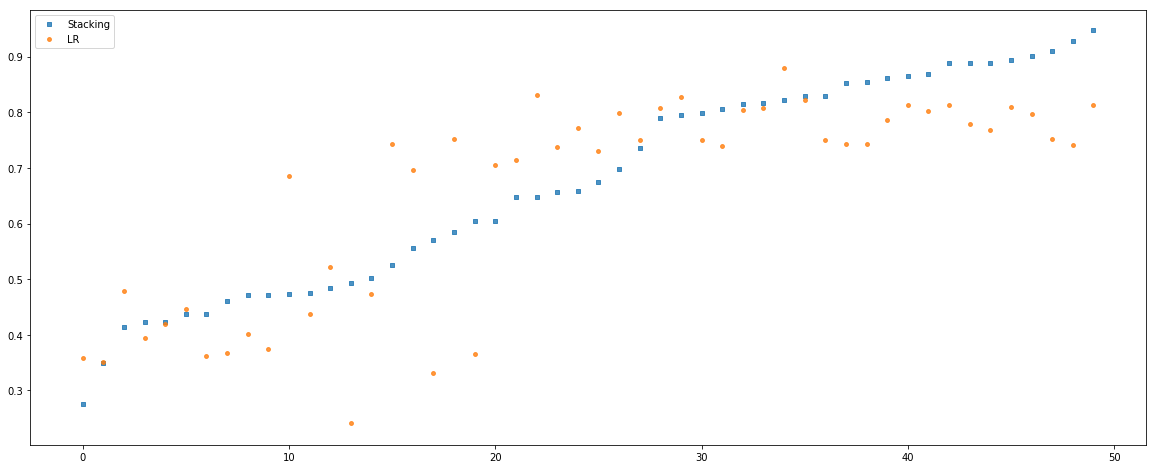

In [36]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(111)

sns.regplot(temp.index.values, temp['Stacking Probs'].values, fit_reg=False, scatter_kws={"s": 10}, marker='s', label='Stacking')
sns.regplot(temp.index.values, temp['LR Probs'].values, fit_reg=False, scatter_kws={"s": 15}, marker='o', label='LR')
plt.legend(loc='upper left');
plt.show()

As we can see here, the stacking predictions which yielded the best results is more consistent and smoother in terms of predictions. Achieving the sweet spot that balances bias and variance is a really difficult task and the combined error can only be mitagated to a certain extent.

# References

1. https://mlwave.com/kaggle-ensembling-guide/
2. http://manish-m.com/?p=794
3. http://scott.fortmann-roe.com/docs/BiasVariance.html
4. https://www.kaggle.com/general/20728